### DATA PREPARATION

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_standard_weather.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2019-01-01 00:00:00,2.334143,25.7,96.0,12.9,7.5
2019-01-01 00:15:00,2.344050,25.7,96.0,12.9,7.5
2019-01-01 00:30:00,2.500311,25.7,96.0,12.9,7.5
2019-01-01 00:45:00,2.432096,25.7,96.0,12.9,7.5
2019-01-01 01:00:00,2.388465,25.7,96.0,12.9,7.5
...,...,...,...,...,...
2024-05-31 22:45:00,69.132420,29.8,68.0,0.0,10.8
2024-05-31 23:00:00,69.132420,29.8,68.0,0.0,10.8
2024-05-31 23:15:00,68.774401,29.8,68.0,0.0,10.8


In [4]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [5]:
scaler = StandardScaler()

In [6]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2019-01-01 00:00:00,-0.926090,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 00:15:00,-0.924906,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 00:30:00,-0.906232,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 00:45:00,-0.914384,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 01:00:00,-0.919598,-1.510370,2.072502,0.764111,-0.170246
...,...,...,...,...,...
2022-12-31 22:45:00,-0.862522,0.644466,0.566106,2.975064,-2.743848
2022-12-31 23:00:00,-0.855322,0.644466,0.566106,2.975064,-2.743848
2022-12-31 23:15:00,-0.857181,0.644466,0.566106,2.975064,-2.743848


In [7]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2023-01-01 00:00:00,-0.851430,0.082335,0.797859,0.266869,-0.204561
2023-01-01 00:15:00,-0.845244,0.082335,0.797859,0.266869,-0.204561
2023-01-01 00:30:00,-0.848134,0.082335,0.797859,0.266869,-0.204561
2023-01-01 00:45:00,-0.871030,0.082335,0.797859,0.266869,-0.204561
2023-01-01 01:00:00,-0.842770,0.082335,0.797859,0.266869,-0.204561
...,...,...,...,...,...
2024-05-31 22:45:00,7.056613,2.330858,-1.172043,-0.381322,0.962138
2024-05-31 23:00:00,7.056613,2.330858,-1.172043,-0.381322,0.962138
2024-05-31 23:15:00,7.013828,2.330858,-1.172043,-0.381322,0.962138


In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


<h4>SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data. Nantinya parameter `validation_split` di `model.fit` akan melakukan splitting data train

In [9]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(140160, 96, 5) (140160,)
(49536, 96, 5) (49536,)


### TRAINING WITH BIDIRECTIONAL-LSTM

In [13]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 96, 256)             │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,697 (1.15 MB)

 Trainable params: 301,697 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.1645 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.0776 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 0.0293 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.0221 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.0209 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.0197 - val_loss: 0.0146 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0199 - val_loss: 0.0113 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - loss: 0.0158 - val_loss: 0.0093 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - loss: 0.0145 - val_loss: 0.

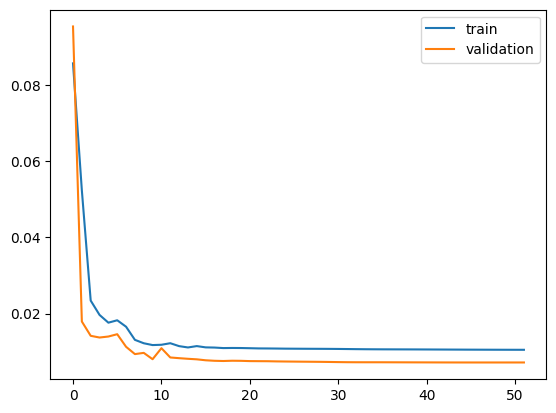

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [17]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


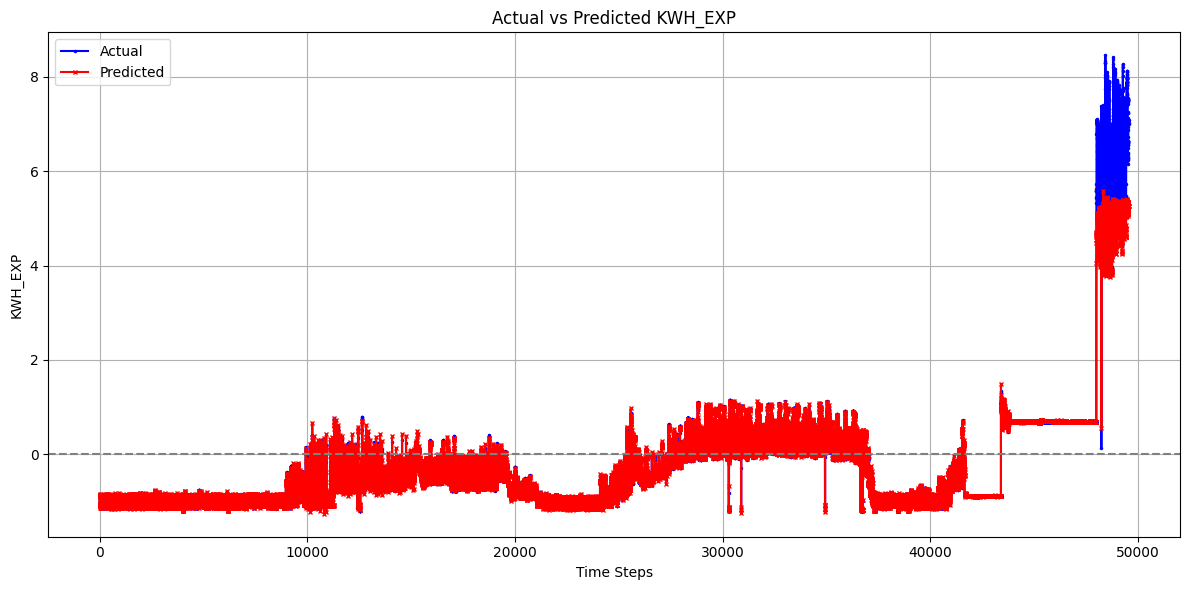

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.07700790847658749
MAE: 0.06696661301522608
R2: 0.9571689944465056
MAPE: 0.3203770175973313


### TRAINING WITH LSTM + ATTENTION LAYER

In [20]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 96, 128)             │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.2831 - val_loss: 0.0851 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.1383 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.1260 - val_loss: 0.0730 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0997 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0807 - val_loss: 0.0582 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0776 - val_loss: 0.0723 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0655 - val_loss: 0.0620 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0585 - val_loss: 0.0554 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0505 - val_loss: 0.0397 - l

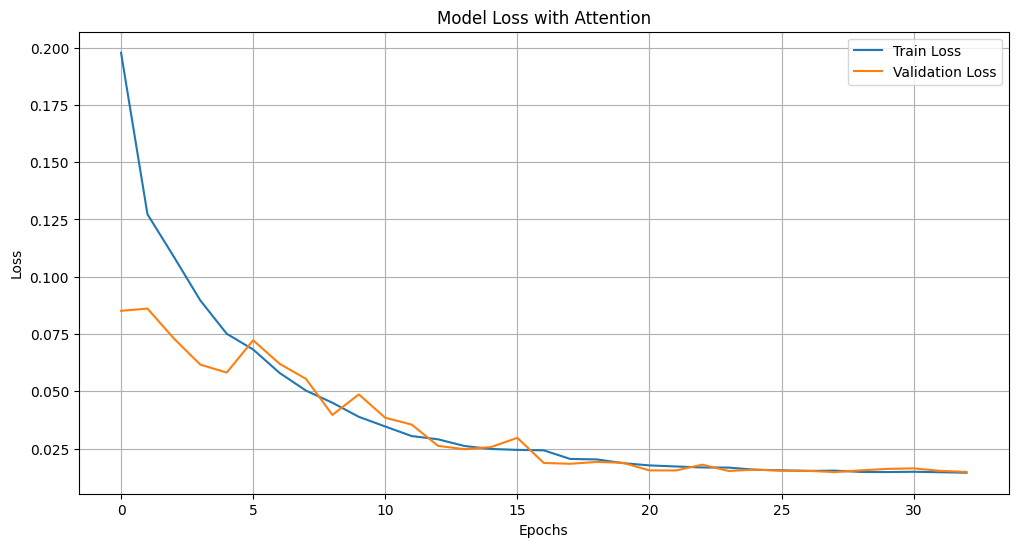

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [21]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

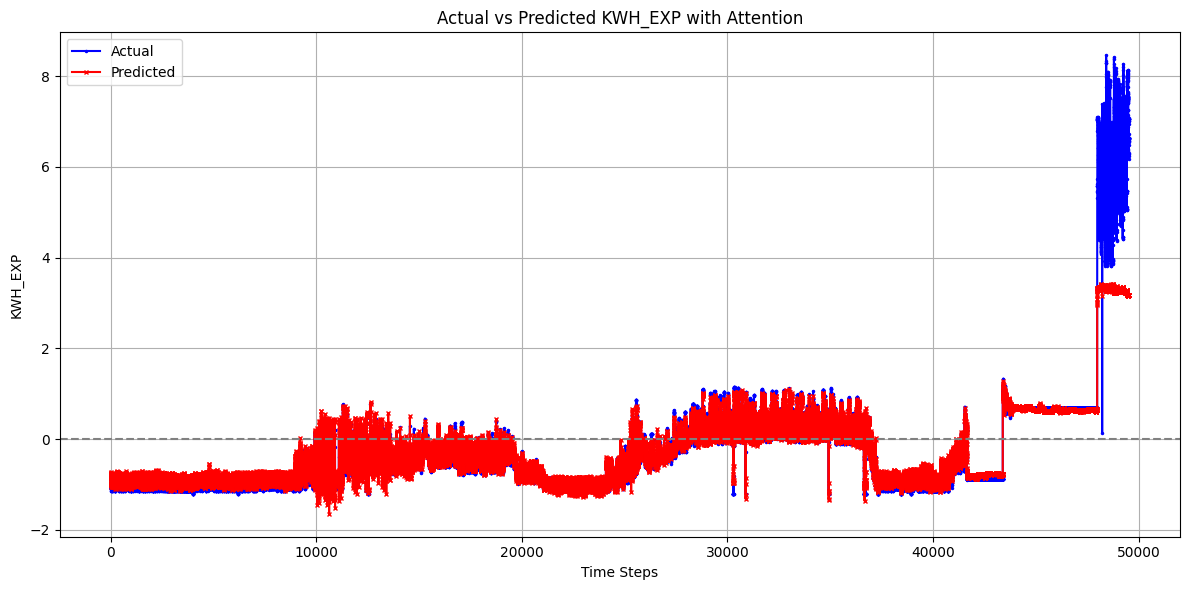

In [22]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [23]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.34044014952731383
MAE: 0.1665492322492387
R²: 0.8106506951884045
MAPE: 0.5937020393071291


### TRAINING WITH BIDIRECTIONAL-LSTM + ATTENTION LAYER

In [24]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 96, 256)             │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,697 (1.15 MB)

 Trainable params: 301,697 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - loss: 0.3005 - val_loss: 0.0684 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - loss: 0.1130 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0815 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0460 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0322 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0224 - val_loss: 0.0163 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0246 - val_loss: 0.0124 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0201 - val_loss: 0.0117 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0184 - val_loss: 0.

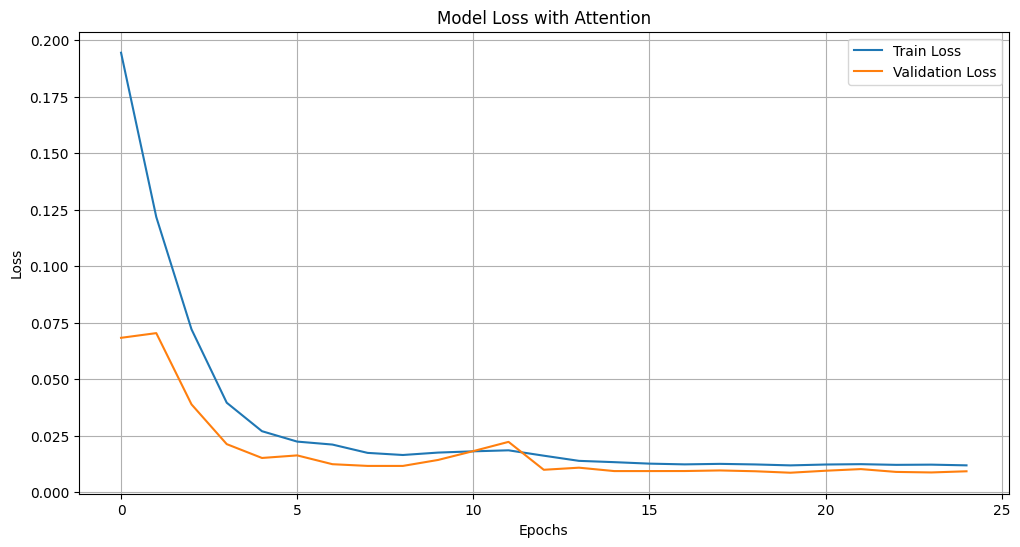

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


In [25]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

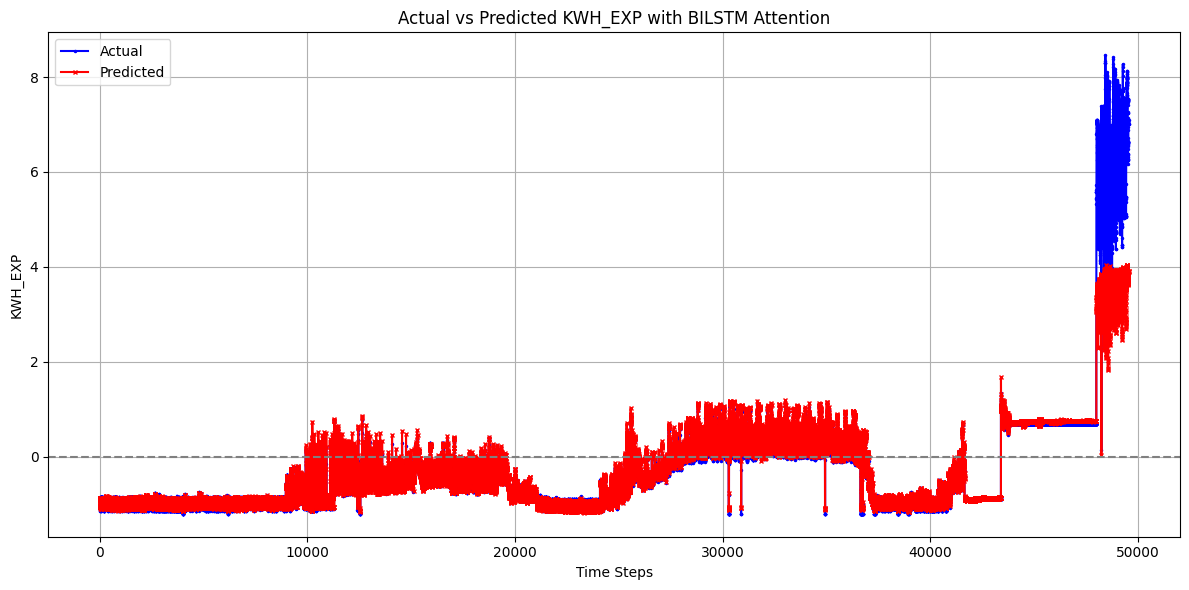

In [26]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [27]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.27150161818570206
MAE: 0.12905453390909596
R²: 0.8489935962897897
MAPE: 0.6095219733689348


### TRAINING WITH LSTM

In [28]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 96, 256)             │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,697 (1.15 MB)

 Trainable params: 301,697 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - loss: 0.0261 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0276 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0197 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0217 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0195 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0169 - val_loss: 0.0143 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0169 - val_loss: 0.0116 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0156 - val_loss: 0.0114 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0170 - val_loss: 0.

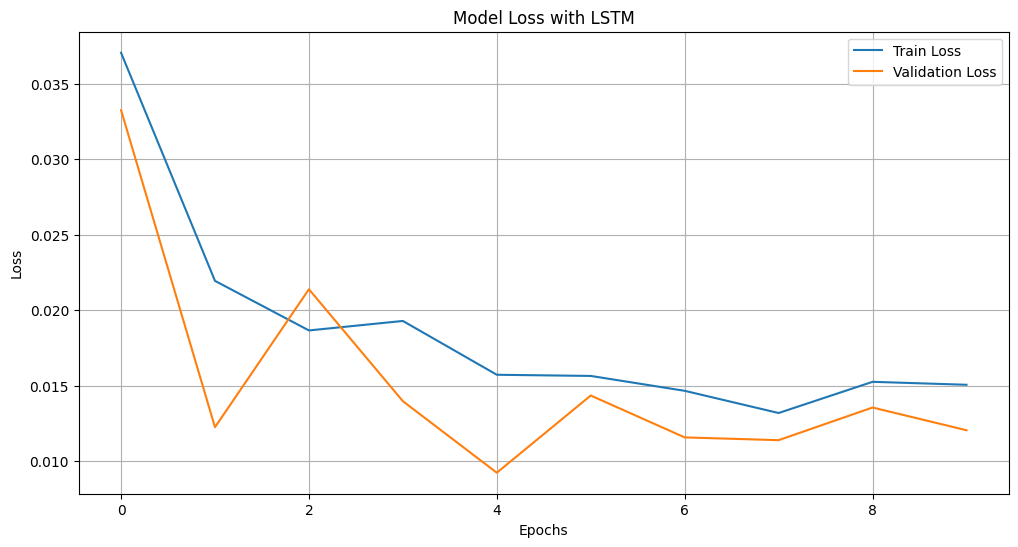

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


In [29]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

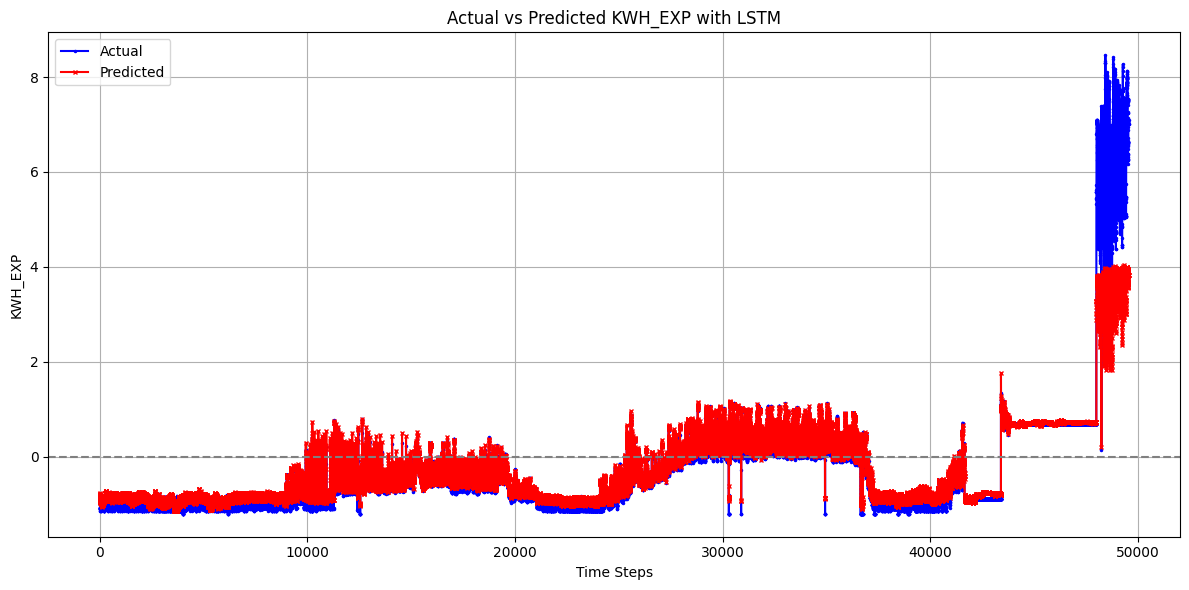

In [30]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [31]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.27560912196934095
MAE: 0.16069280771683678
R²: 0.8467090449904705
MAPE: 0.7764846071642296
